# Gaussian Processes in PyTorch from Scratch

In [4]:
import matplotlib.pyplot as plt
import torch

In [83]:
def squared_exp(x1, x2, length_scale=1):
    """Squared exponential kernel.
    
    Operates on torch tensors.
    """
    return torch.exp(-((x1-x2)**2)/(2*length_scale**2))

def generate_covariance_matrix(x1, x2, kernel, length_scale=1):
    """Generates a kernelised covariance matrix between x1 and x2.
    
    Operates on torch tensors.
    """
    
    x1 = x1.reshape(-1, 1)
    x1 = torch.cat([x1]*len(x2), axis=1)
    
    x2 = x2.reshape(1, -1)
    x2 = torch.cat([x2]*len(x1), axis=0)
    
    K = kernel(x1, x2, length_scale)
    
    return K

### Generate data

In [93]:
N_CONTEXT = 3
N_TARGET = 100
LENGTH_SCALE = 3
Z_CONFIDENCE = 1.96

def data_gen_function(x):
    
    y = x**3
    y = (y - torch.mean(y))/torch.std(y)
    
    return y

x_ground_truth = torch.linspace(0, 10, 500)
y_ground_truth = data_gen_function(x_ground_truth)

x_context = torch.rand((N_CONTEXT))*10
y_context = data_gen_function(x_context) + torch.randn((N_CONTEXT))

x_target = torch.linspace(0, 10, N_TARGET)

### Calculate covariance matrices

In [94]:
K_11 = generate_covariance_matrix(x_target,
                                  x_target,
                                  squared_exp,
                                  length_scale=LENGTH_SCALE)
K_12 = generate_covariance_matrix(x_target,
                                  x_context,
                                  squared_exp,
                                  length_scale=LENGTH_SCALE)
K_22 = generate_covariance_matrix(x_context,
                                  x_context,
                                  squared_exp,
                                  length_scale=LENGTH_SCALE)

# Calculate inverse of K_22 using Cholesky decomposition. This is more efficient but can only
# be done on positive-definite or positive-semidefinite matrices.

# To make this part stable we need to add noise to the diagonal.
stability_noise = torch.eye(len(x_context)) * 2e-2
L = torch.linalg.cholesky(K_22 + stability_noise)
L_inv = torch.linalg.inv(L)
K_22_inverse = L_inv.T @ L_inv

### Get mean and standard deviations for predictions
Let $(x_{1}, y_{1})$ be the prediction inputs and targets, and $(x_{2}, y_{2})$ be the context inputs and targets. $\Sigma_{ij}$ denotes the covariance matrix between $y_{i}$ and $y_{j}$.

Assuming $y_{1} \cup y_{2}$ are jointly Gaussian, we have that:

$$E[y_{1}|y_{2}] = \mu_{1} + \Sigma_{12}\Sigma_{22}^{-1}(\mu_{2}-y_{2})$$

$$Var(y_{1}|y_{2}) = \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}$$

These are simply the conditional probabilites for mulivariate Gaussian distributions.

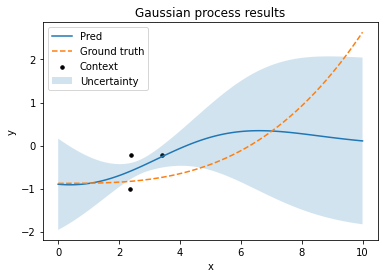

In [95]:
target_means = K_12 @ K_22_inverse
target_means = (target_means @ y_context.reshape(-1, 1)).reshape(-1)

target_var = torch.diag(K_11 - K_12 @ K_22_inverse @ K_12.T)
uncertainty = torch.sqrt(target_var)

plt.plot(x_target, target_means, label="Pred")
plt.plot(x_ground_truth, y_ground_truth, label="Ground truth", linestyle='--')
plt.scatter(x_context, y_context, label='Context', color='black', s=12)
plt.fill_between(x_target,
                 target_means - Z_CONFIDENCE*uncertainty,
                 target_means + Z_CONFIDENCE*uncertainty,
                 alpha=0.2,
                 label="Uncertainty")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian process results")
plt.show()